In [ ]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false" # Disable some XLA behaviors
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" # Force deterministic algorithms, reduce search

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import KFold
import itertools


2025-12-18 15:49:01.240416: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 15:49:01.378086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 15:49:03.310929: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Ensure GPU memory allocation on demand to prevent OOM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


#### Data Preparation and Preprocessing
load and normalize images

In [4]:
import tensorflow as tf

# Define dataset paths
train_dir = "/home/zyh/Fruit-Classifier/data/train_augment"    # directory with subfolders for each class (train set)


IMG_SIZE = 224   # image size (can be adjusted as needed)



model structure

In [5]:
from tensorflow.keras import layers, models, regularizers

def create_cnn_model(activation='relu', dropout_rate=0.2, l2_rate=0.0):
    model = models.Sequential()
    # Convolutional layers with chosen activation and optional L2 regularization
    model.add(layers.Conv2D(32, (3,3), padding='same', activation=activation, 
                             input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation=activation,
                             kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, (3,3), padding='same', activation=activation,
                             kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.MaxPooling2D(pool_size=2))
    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation=activation, 
                            kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(32, activation=activation, 
                            kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(4, activation='softmax'))  # 4 output classes
    return model

As shown above, we parameterize the activation function, dropout rate, and L2 regularization rate so that these can be tuned. By default, the original model used ReLU activations and a dropout rate of 0.2 in two places. We include the option to use Leaky ReLU as an alternative; if Leaky ReLU is selected, we will insert layers.LeakyReLU() layers after each linear layer (since Keras layers.Dense or Conv2D do not accept leaky_relu string directly, we would use activation=None and add a LeakyReLU layer manually).

Regularization: We have two forms of regularization to consider – dropout and L2 weight decay. Dropout randomly zeros out a fraction of neurons during training to prevent co-adaptation of features, while L2 penalizes large weights. Both are known to help reduce overfitting. In the model, dropout layers are included as shown; L2 regularization is applied to convolutional and dense layers via kernel_regularizer=regularizers.l2(l2_rate). We will tune the dropout_rate (e.g., try values like 0.0 = no dropout vs 0.5) and the l2_rate (e.g., 0.0 = no L2 vs a small value like 0.001) as hyperparameters.

Initially, we keep other aspects constant (the number of layers/units as given). The model will be compiled with a chosen optimizer and learning rate (also to be tuned). For example, using Adam optimizer with a certain learning rate as in the original code:

In [6]:
# model = create_cnn_model(activation='relu', dropout_rate=0.2, l2_rate=0.0)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # example learning rate
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


#### Hyperparameter Tuning with Grid Search and K-Fold Cross-Validation

To systematically find the best hyperparameter combination, we employ grid search over the specified hyperparameter ranges, coupled with K-fold cross-validation for robust evaluation. Grid search will exhaustively try all combinations of the provided hyperparameters, and K-fold CV means that for each combination, the training data is further split into K folds to evaluate the model’s performance across different subsets. This helps ensure the hyperparameter choice generalizes well and is not overfitting to one particular train/validation split.

Hyperparameters to tune:

Learning Rate: We will search values in the range 0.1 to 0.001. Given the prompt’s suggestion, we use a logarithmic scale: e.g. [0.1, 0.01, 0.001]. 

Optimizer: We consider two optimizers – Stochastic Gradient Descent (SGD) and Adam. These represent different update algorithms; SGD could be used with momentum, but here we’ll use plain SGD vs Adam.

Batch Size: Try [16, 32, 64]. Batch size affects training stability and speed.

Activation Function: Either ReLU or LeakyReLU. We will implement LeakyReLU with a negative slope (default 0.2) if chosen.

Dropout Rate: Try e.g. [0.0, 0.5] – either no dropout or 50% dropout. (We could also test an intermediate like 0.2 as in the original.)

L2 Regularization (weight decay) factor: Try [0.0, 0.001] – either no L2 penalty or a small penalty.

Given these choices, the grid has 3×2×3×2×2×2 = 144 possible combinations.  For demonstration, let's set K = 5 (5-fold cross-validation) by default.


Loading data into memory: /home/zyh/Fruit-Classifier/data/train_augment ...
Detected classes: ['apple', 'banana', 'mixed', 'orange']
Data loading complete! X shape: (400, 224, 224, 3), y shape: (400, 4)

Starting Grid Search (Target: Minimum Validation Loss)
Total combinations: 24 (with 5-Fold CV)

[1/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.2} ...

/home/zyh/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766044147.103955 3490036 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-12-18 15:49:08.960584: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


 -> Loss: 1.2702 (±0.0550)
   New Best Model found! (Low Loss: 1.2702)
[2/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.4} ... -> Loss: 1.3375 (±0.0269)
[3/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 32, 'activation': 'relu', 'dropout_rate': 0.2} ... -> Loss: 1.3400 (±0.0300)
[4/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 32, 'activation': 'relu', 'dropout_rate': 0.4} ... -> Loss: 1.3608 (±0.0174)
[5/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'Adam', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.2} ... -> Loss: 0.6164 (±0.1303)
   New Best Model found! (Low Loss: 0.6164)
[6/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'Adam', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.4} ... -> Loss: 0.5631 (±0.0810)
   New Best Model found! (Low Loss: 0.5631)
[7/24] Testing: {'learning_rate': 0.001, 'optimizer_na

/tmp/ipykernel_3490036/2518199702.py:151: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Label', y='mean_loss', data=df_results, palette='viridis', ci=None)
/tmp/ipykernel_3490036/2518199702.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='mean_loss', data=df_results, palette='viridis', ci=None)


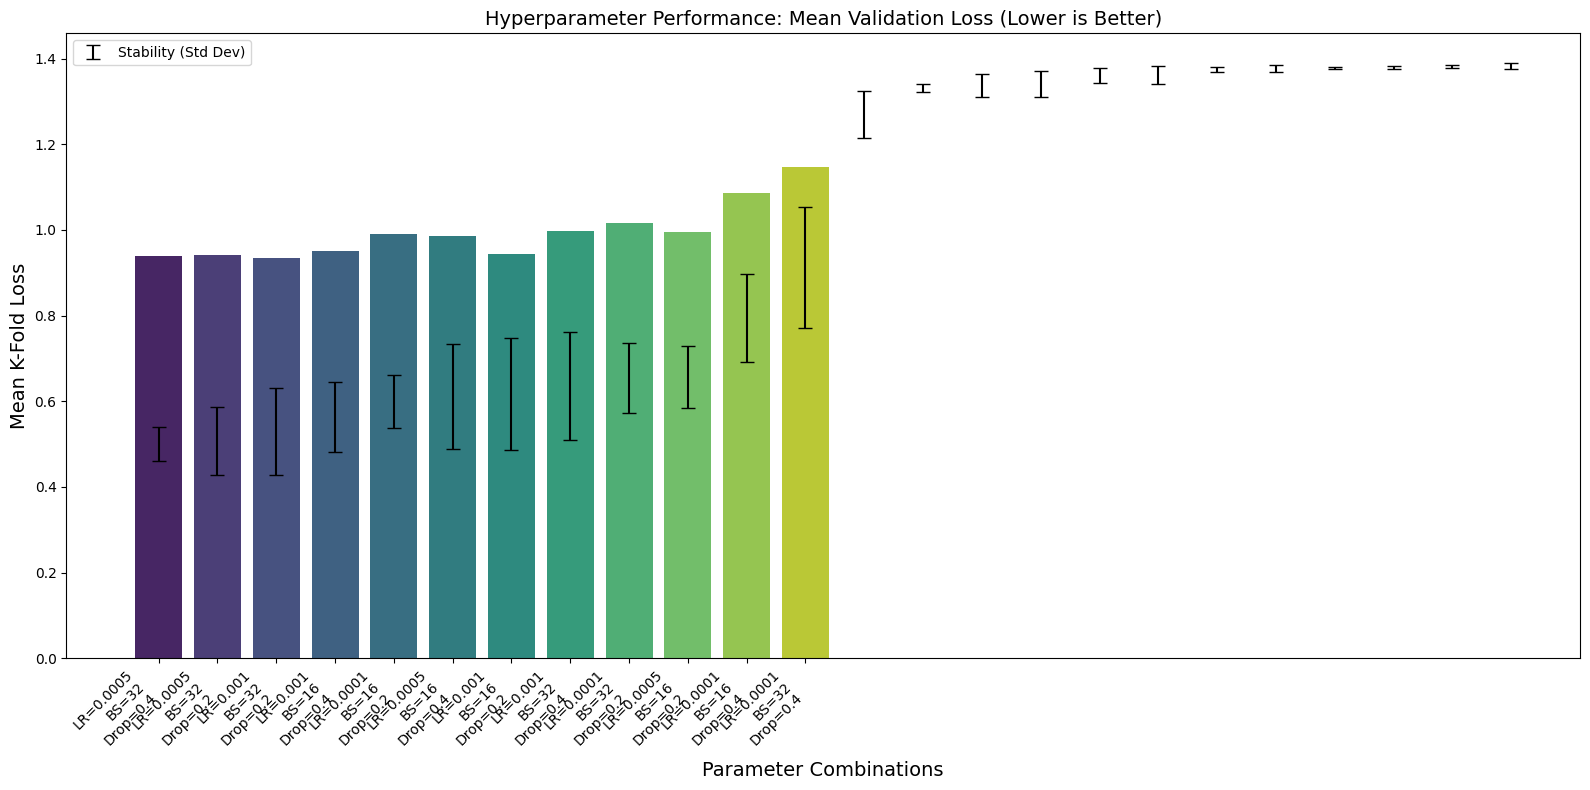


Chart Guide:
1. Height of bar: Average Loss (Lower is better).
2. Black line (Error Bar): Stability. Shorter lines mean the model is more stable across different data splits.


In [7]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Wrap the model creation in KerasClassifier for use in GridSearchCV
def build_model(learning_rate=0.01, optimizer_name='Adam', activation='relu', 
                dropout_rate=0.2, l2_rate=0.0):
    # Build the CNN model with given hyperparams
    model = create_cnn_model(activation=activation, dropout_rate=dropout_rate, l2_rate=l2_rate)
    # Choose optimizer
    if optimizer_name == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:  # 'SGD'
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)
    return model


# Load all data into memory for speed optimization
def load_data_to_memory(data_dir, img_size):
    print(f"Loading data into memory: {data_dir} ...")
    X = []
    y = []
    # Ensure consistent class name order: ['apple', 'banana', 'mixed', 'orange']
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    print(f"Detected classes: {classes}")
    
    for label_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        files = os.listdir(class_dir)
        for fname in files:
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                fpath = os.path.join(class_dir, fname)
                # Load and resize image
                img = load_img(fpath, target_size=(img_size, img_size))
                # Convert to array and normalize (0-1)
                img_array = img_to_array(img) / 255.0
                
                X.append(img_array)
                y.append(label_idx)
                
    X = np.array(X)
    # Convert labels to one-hot encoding (e.g., [0, 1, 0, 0])
    y = tf.keras.utils.to_categorical(np.array(y), num_classes=len(classes))
    print(f"Data loading complete! X shape: {X.shape}, y shape: {y.shape}")
    return X, y



# Load all data into RAM once (320 images occupy approximately 150MB~200MB memory)
X_all, y_all = load_data_to_memory(train_dir, IMG_SIZE)


# Fast Grid Search
param_grid = {
    'learning_rate': [0.001, 0.0005,0.0001],
    'optimizer_name': ['SGD', 'Adam'],
    'batch_size': [16, 32],
    'activation': ['relu'],
    'dropout_rate': [0.2,0.4],
    #'l2_rate': [0.0, 0.001]
}

combinations = list(itertools.product(*param_grid.values()))
total_runs = len(combinations)
keys = list(param_grid.keys())

# Storage for results
experiment_results = []
best_loss = float('inf') # Finding Minimum
best_params = {}

print(f"\nStarting Grid Search (Target: Minimum Validation Loss)")
print(f"Total combinations: {total_runs} (with 5-Fold CV)\n")

# Use 5-Fold as requested
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for run_idx, combo in enumerate(combinations):
    params = dict(zip(keys, combo))
    # Extract batch_size
    build_args = {k: v for k, v in params.items() if k != 'batch_size'}
    current_batch_size = params['batch_size']
    
    fold_losses = []
    fold_accs = []
    
    print(f"[{run_idx+1}/{total_runs}] Testing: {params} ...", end="", flush=True)
    
    for train_idx, val_idx in kfold.split(X_all):
        tf.keras.backend.clear_session() # Clear GPU memory
        
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]
        
        model = build_model(**build_args)
        
        # Training
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=current_batch_size,
            epochs=15, 
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, monitor='val_loss')],
            verbose=0 # Silent mode for speed
        )
        
        # Evaluation
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        fold_losses.append(val_loss)
        fold_accs.append(val_acc)
        


    # Calculate Statistics
    mean_loss = np.mean(fold_losses)
    std_loss = np.std(fold_losses)
    mean_acc = np.mean(fold_accs)
    
    print(f" -> Loss: {mean_loss:.4f} (±{std_loss:.4f})")
    
    # Store results
    res_entry = params.copy()
    res_entry['mean_loss'] = mean_loss
    res_entry['std_loss'] = std_loss
    res_entry['mean_acc'] = mean_acc
    # Create short label for plotting
    res_entry['Label'] = f"LR={params['learning_rate']}\nBS={params['batch_size']}\nDrop={params['dropout_rate']}"
    experiment_results.append(res_entry)

    # Check for best (Minimum Loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_params = params
        print(f"   New Best Model found! (Low Loss: {best_loss:.4f})")

print("\n================ Search Complete ================")
print(f"Best Loss: {best_loss:.4f}")
print(f"Best Params: {best_params}")


# Visualization 
if len(experiment_results) > 0:
    df_results = pd.DataFrame(experiment_results)
    
    # Sort by mean loss for better visualization
    df_results = df_results.sort_values(by='mean_loss', ascending=True)
    
    plt.figure(figsize=(16, 8))
    
    # Bar plot for Mean Loss
    sns.barplot(x='Label', y='mean_loss', data=df_results, palette='viridis', ci=None)
    
    # Add Error Bars (Standard Deviation)
    plt.errorbar(x=range(len(df_results)), 
                 y=df_results['mean_loss'], 
                 yerr=df_results['std_loss'], 
                 fmt='none', c='black', capsize=5, label='Stability (Std Dev)')
    
    plt.title('Hyperparameter Performance: Mean Validation Loss (Lower is Better)', fontsize=14)
    plt.ylabel('Mean K-Fold Loss', fontsize=14)
    plt.xlabel('Parameter Combinations', fontsize=14)
    plt.xticks(rotation=45,ha='right', fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nChart Guide:")
    print("1. Height of bar: Average Loss (Lower is better).")
    print("2. Black line (Error Bar): Stability. Shorter lines mean the model is more stable across different data splits.")